## Lab 3

### Part 1. Overfit it (1.5 points)

Будем работать с датасетом [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) (*hint: он доступен в torchvision*).

Ваша задача состоит в следующем:
1. Обучить сеть, которая покажет >= 0.92 test accuracy.
2. Пронаблюдать и продемонстрировать процесс переобучения сети с увеличением числа параметров (==нейронов) и/или числа слоев и продемонстрировать это наглядно (например, на графиках).
3. Попробовать частично справиться с переобучением с помощью подходящих приемов (Dropout/batchnorm/augmentation etc.)

*Примечание*: Пункты 2 и 3 взаимосвязаны, в п.3 Вам прелагается сделать полученную в п.2 сеть менее склонной к переобучению. Пункт 1 является независимым от пунктов 2 и 3.

In [ ]:
import torch
from torch import nn
import torchvision

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [ ]:
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
train_size = int(0.7 * len(trainset))
test_size = len(trainset) - train_size
trainset, devset = torch.utils.data.random_split(trainset, [train_size, test_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
devloader = torch.utils.data.DataLoader(devset, batch_size=100, shuffle=True)

  0%|          | 16384/26421880 [00:00<02:47, 157549.16it/s]

26427392it [00:00, 79012621.96it/s]                            


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


32768it [00:00, 471979.29it/s]
  5%|▍         | 212992/4422102 [00:00<00:02, 1878979.31it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


4423680it [00:00, 24233342.54it/s]                           
8192it [00:00, 152105.58it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


In [ ]:
# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)

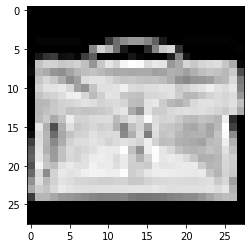

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def imshow(img):
    img = img / 2 + 0.     # unnormalize
    img = img.squeeze()
    plt.imshow(img, cmap='gray')
    
images, label = next(iter(trainloader))
imshow(images[0, :])

# Task 1

In [ ]:
class MyModel(nn.Module):
    def __init__(self, hidden=[1024], dropout=0.5):
        super(MyModel, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(32*6*6, 1024)
        self.drop = nn.Dropout2d(dropout)
        self.fc2 = nn.Linear(1024, 10)
        #self.fc3 = nn.Linear(in_features=16, out_features=10)
        hidden = [32*6*6]+hidden#+[10]
        fc = [nn.Sequential(
                nn.Linear(hidden[i], hidden[i+1]),
                nn.ReLU(),
                nn.Dropout(dropout) 
            ) for i in range(len(hidden)-1)]
        fc += nn.Sequential(
                nn.Linear(hidden[-1], 10),
            )
        self.fc = nn.Sequential(*fc)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.drop(out)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.drop(out)
        
        out = self.fc(out)
        #out = self.fc1(out)
        #out = nn.ReLU()(out)
        #out = self.drop(out)
        #out = self.fc2(out)
        #out = self.fc3(out)
        
        return out

In [ ]:
model = MyModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
criterion = nn.CrossEntropyLoss()
epochs = 100
for i in range(epochs):
  trainloss = 0
  model.train()
  for images, labels in trainloader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()

    predicted_labels = model(images)
    loss = criterion(predicted_labels, labels)

    loss.backward()
    optimizer.step()
    
    trainloss += loss.item()
  else:
    print(f"{i} Training loss: {trainloss/len(trainloader)}")

  with torch.no_grad():  
    devloss = 0
    total_correct = 0
    total_num = 0
    model.eval()
    for images, labels in devloader:
      images, labels = images.to(device), labels.to(device)

      predicted_labels = model(images)
      loss = criterion(predicted_labels, labels)

      correct = predicted_labels.argmax(dim=-1) == labels
      total_correct += correct.sum().cpu().numpy()
      total_num += images.shape[0]

      devloss += loss.item()
    else:
      print(f"{i} Dev loss: {devloss/len(devloader)}")
      print('Accuracy:', total_correct / float(total_num))
      scheduler.step(devloss)

0 Training loss: 0.6487961075845219
0 Dev loss: 0.4194583712352647
Accuracy: 0.8408333333333333
1 Training loss: 0.4719908275064968
1 Dev loss: 0.3533339517811934
Accuracy: 0.8702222222222222
2 Training loss: 0.4209769487026192
2 Dev loss: 0.32548343067367874
Accuracy: 0.8803888888888889
3 Training loss: 0.38988613124404636
3 Dev loss: 0.2981102480656571
Accuracy: 0.8894444444444445
4 Training loss: 0.3684269768141565
4 Dev loss: 0.2904488850798872
Accuracy: 0.8922222222222222
5 Training loss: 0.35317232073062943
5 Dev loss: 0.2773769830663999
Accuracy: 0.8987222222222222
6 Training loss: 0.33753485101319497
6 Dev loss: 0.2662924248725176
Accuracy: 0.9000555555555556
7 Training loss: 0.3263007906930787
7 Dev loss: 0.26976595976286466
Accuracy: 0.8988333333333334
8 Training loss: 0.3210953705190193
8 Dev loss: 0.25926888460914294
Accuracy: 0.9050555555555555
9 Training loss: 0.3143001333233856
9 Dev loss: 0.26018914133310317
Accuracy: 0.9018333333333334
10 Training loss: 0.3024793160458

In [ ]:
total_correct = 0
total_num = 0
with torch.no_grad():
  model.eval()
  for images, labels in testloader:
    images, labels = images.to(device), labels.to(device) 
    
    correct = model(images).argmax(dim=-1) == labels
    total_correct += correct.sum().cpu().numpy()
    total_num += images.shape[0]
  
print(f'Accuracy: {total_correct / float(total_num)}')

Accuracy: 0.9262


## Task 2

In [ ]:
models = [MyModel(hidden=[10], dropout=0).to(device), \
          MyModel(hidden=[64], dropout=0).to(device), \
          MyModel(hidden=[1024], dropout=0).to(device), \
          MyModel(hidden=[64, 64], dropout=0).to(device), \
          MyModel(hidden=[1024, 512], dropout=0).to(device), \
          MyModel(hidden=[1024, 2048, 512], dropout=0).to(device)
]

In [ ]:
def train_range(models, epochs=20):  
  trainlist = {}
  devlist = {}
  for m_id, model in enumerate(models):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    trainlist[m_id] = []
    devlist[m_id] = [] 
    for i in range(epochs):
      trainloss = 0
      model.train()
      for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        predicted_labels = model(images)
        loss = criterion(predicted_labels, labels)
        loss.backward()
        optimizer.step()

        trainloss += loss.item()
      else:
        print(f"{i} Training loss: {trainloss/len(trainloader)}")
        trainlist[m_id].append(trainloss/len(trainloader))

      with torch.no_grad():  
        devloss = 0
        total_correct = 0
        total_num = 0
        model.eval()
        for images, labels in devloader:
          images, labels = images.to(device), labels.to(device)

          predicted_labels = model(images)
          loss = criterion(predicted_labels, labels)

          correct = predicted_labels.argmax(dim=-1) == labels
          total_correct += correct.sum().cpu().numpy()
          total_num += images.shape[0]

          devloss += loss.item()
        else:
          print(f"{i} Dev loss: {devloss/len(devloader)}")
          print('Accuracy:', total_correct / float(total_num))
          devlist[m_id].append(devloss/len(devloader))
  return trainlist, devlist

In [ ]:
trainlist, devlist = train_range(models, epochs=30)

0 Training loss: 0.530483706508364
0 Dev loss: 0.35422115375598273
Accuracy: 0.8740555555555556
1 Training loss: 0.3197890439913386
1 Dev loss: 0.3361713954971896
Accuracy: 0.8812777777777778
2 Training loss: 0.28060217877583843
2 Dev loss: 0.2958588589396742
Accuracy: 0.8951111111111111
3 Training loss: 0.2557643698971896
3 Dev loss: 0.29555682759318086
Accuracy: 0.8958333333333334
4 Training loss: 0.23662701305888947
4 Dev loss: 0.28484155283206036
Accuracy: 0.901
5 Training loss: 0.22194208023803574
5 Dev loss: 0.26574249669081634
Accuracy: 0.9060555555555555
6 Training loss: 0.20996138646843887
6 Dev loss: 0.2635406992915604
Accuracy: 0.9077777777777778
7 Training loss: 0.2016153011471033
7 Dev loss: 0.2670682195160124
Accuracy: 0.9031666666666667
8 Training loss: 0.1915283469394559
8 Dev loss: 0.2666404771722025
Accuracy: 0.9063333333333333
9 Training loss: 0.17812868170440196
9 Dev loss: 0.25812224118659893
Accuracy: 0.9106666666666666
10 Training loss: 0.17070904908080894
10 Dev

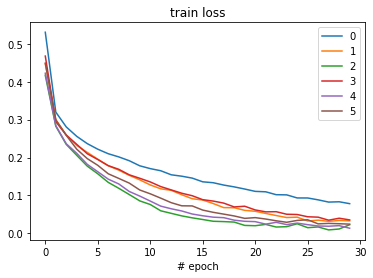

In [ ]:
# train loss
from matplotlib import pyplot as plt
for i, ls in trainlist.items():
  plt.plot(ls, label=i)
plt.title('train loss')
plt.xlabel('# epoch')
plt.legend()
plt.show()

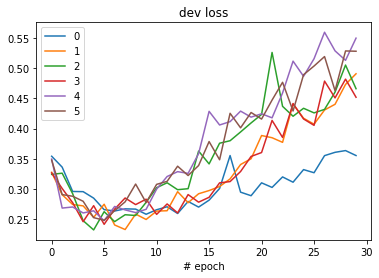

In [ ]:
# train loss
from matplotlib import pyplot as plt
for i, ls in devlist.items():
  plt.plot(ls, label=i)
plt.title('dev loss')
plt.xlabel('# epoch')
plt.legend()
plt.show()

# Task 3

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
models = [MyModel(hidden=[64], dropout=0.3).to(device), \
          MyModel(hidden=[1024], dropout=0.5).to(device), \
          MyModel(hidden=[64, 64], dropout=0.3).to(device), \
          MyModel(hidden=[1024, 512], dropout=0.5).to(device), \
          MyModel(hidden=[1024, 2048, 512], dropout=0.5).to(device)
]

In [ ]:
trainlist, devlist = train_range(models, epochs=30)

0 Training loss: 0.6264096159310568
0 Dev loss: 0.386027645236916
Accuracy: 0.8594444444444445
1 Training loss: 0.43488364673796154
1 Dev loss: 0.33227933852208985
Accuracy: 0.8792222222222222
2 Training loss: 0.38686365644846643
2 Dev loss: 0.30122371059325004
Accuracy: 0.8873888888888889
3 Training loss: 0.35924866884237244
3 Dev loss: 0.28559031362334886
Accuracy: 0.8968333333333334
4 Training loss: 0.34476235118650256
4 Dev loss: 0.29216935435930885
Accuracy: 0.8915555555555555
5 Training loss: 0.3322999677665177
5 Dev loss: 0.270795561828547
Accuracy: 0.8993333333333333
6 Training loss: 0.3177852961633887
6 Dev loss: 0.25667858666015997
Accuracy: 0.9070555555555555
7 Training loss: 0.30711643057210103
7 Dev loss: 0.2563823249604967
Accuracy: 0.9063333333333333
8 Training loss: 0.30072961160469625
8 Dev loss: 0.2500082121955024
Accuracy: 0.9088888888888889
9 Training loss: 0.2908794625884011
9 Dev loss: 0.2425592587225967
Accuracy: 0.9102777777777777
10 Training loss: 0.29031274132

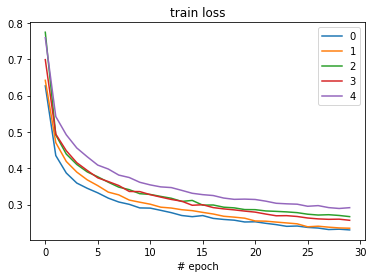

In [ ]:
# train loss
from matplotlib import pyplot as plt
for i, ls in trainlist.items():
  plt.plot(ls, label=i)
plt.title('train loss')
plt.xlabel('# epoch')
plt.legend()
plt.show()

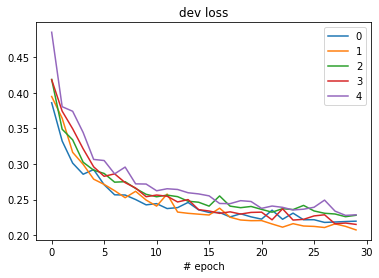

In [ ]:
# train loss
from matplotlib import pyplot as plt
for i, ls in devlist.items():
  plt.plot(ls, label=i)
plt.title('dev loss')
plt.xlabel('# epoch')
plt.legend()
plt.show()